In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
from IPython.display import HTML, display # jupyter 사진넣기
import time                      # excution time 계산
from datetime import datetime   # system time 
import json                     # json save
# from imblearn.over_sampling import SMOTE
from sklearn import tree                  # 결정트리 모형  # Classifier tree
from sklearn.inspection import permutation_importance  # feature 중요도
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer, PolynomialFeatures
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,
                             precision_recall_curve,roc_curve,mean_squared_error,mean_absolute_error,r2_score)
from sklearn.model_selection import learning_curve, ShuffleSplit

from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet
from sklearn.svm import SVC, LinearSVC,LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree 
from sklearn.ensemble import (VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
                            ExtraTreesClassifier,GradientBoostingClassifier,RandomForestRegressor,GradientBoostingRegressor)
from xgboost import XGBClassifier, XGBRegressor     # 사이킷런 wrapper
from lightgbm import LGBMClassifier, LGBMRegressor   # 사이킷런 wrapper
from sklearn.naive_bayes import GaussianNB

import pickle                         # 모델 저장
import matplotlib as mpl              # 한글깨짐
import matplotlib.font_manager as fm  # 한글깨짐
import matplotlib.font_manager        # 한글깨짐


# project

## Clf

### clf sampling 1단계 target 수(52만)만큼 train sample(52만) 합 약 104만건 + scaling 

In [2]:
# df = pd.read_csv('data/NHIS_total_model.csv')
# # df = df.iloc[:10000, :]
# # print(df.info())
# # df.head(3)

In [ ]:
df_copy = df.copy()
#     df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else ( 2 if 100 <= x < 126 else 3))
df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0 )
df_copy.drop('식전혈당(공복혈당)', axis=1, inplace=True)    
# 연령대 코드 --> 연령 decoding 후 drop
df_copy['연령'] =df_copy['연령대코드(5세단위)'].apply( lambda x: x*5 + 17 )
df_copy.drop('연령대코드(5세단위)', axis=1, inplace=True)
print(f"target   count : {df_copy[df_copy['target'] == 1].shape[0]} ({ round(df_copy[df_copy['target'] == 1].shape[0]/df_copy.shape[0], 4)*100 })%")
print(f"target외 count : {df_copy[df_copy['target'] != 1].shape[0]} ({ round(df_copy[df_copy['target'] != 1].shape[0]/df_copy.shape[0], 4)*100 })%")

In [ ]:
# filter
target_count = df_copy[ df_copy['target'] == 1 ].shape[0]
not_target_count = df_copy[ df_copy['target'] != 1 ].shape[0]

# frac 설정 # if (target_count/not_target_count)*2 ==> train : test 비율이 2:1 ==> target 33.3%비율(전체 156만)
frac=round( (target_count/not_target_count), 3) 
df_target = df_copy[ df_copy['target'] == 1 ]
df_X =  df_copy[ df_copy['target'] != 1 ].sample(frac=frac, random_state=1)

# concat
df = pd.concat ([df_target, df_X]).sort_values(by=['기준년도'])

target_count = df[df['target'] == 1].shape[0]
target_ex_count = df[df['target'] != 1].shape[0]
print(f"target   count : {target_count} ({ round( target_count/df.shape[0], 4)*100 })%")
print(f"target외 count : {target_ex_count} ({ round( target_ex_count/df.shape[0], 4)*100 })%")
# shuffle
import sklearn
df = sklearn.utils.shuffle(df)
# df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df.to_csv('./data/NHIS_model_1.csv', sep=',', encoding='utf-8', index=False)

### clf sampling 2단계 4:1 260만

In [ ]:
df = pd.read_csv('data/NHIS_total_model.csv')
df_copy = df
df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0 )
df_copy.drop('식전혈당(공복혈당)', axis=1, inplace=True)    
# 연령대 코드 --> 연령 decoding 후 drop
df_copy['연령'] =df_copy['연령대코드(5세단위)'].apply( lambda x: x*5 + 17 )
df_copy.drop('연령대코드(5세단위)', axis=1, inplace=True)

# filter
target_count = df_copy[ df_copy['target'] == 1 ].shape[0]
not_target_count = df_copy[ df_copy['target'] != 1 ].shape[0]

# frac 설정 # if (target_count/not_target_count)*4 ==> target 33.3%비율(전체 156만)
frac=round( (target_count/not_target_count)*4, 3)  # 4:1 ==> total 260만
df_target = df_copy[ df_copy['target'] == 1 ]
df_X =  df_copy[ df_copy['target'] != 1 ].sample(frac=frac, random_state=1)

# concat
df = pd.concat ([df_target, df_X]).sort_values(by=['기준년도'])

target_count = df[df['target'] == 1].shape[0]
target_ex_count = df[df['target'] != 1].shape[0]
print(f"target   count : {target_count} ({ round( target_count/df.shape[0], 4)*100 })%")
print(f"target외 count : {target_ex_count} ({ round( target_ex_count/df.shape[0], 4)*100 })%")
# shuffle
import sklearn
df = sklearn.utils.shuffle(df)
# df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df.to_csv('./data/NHIS_model_2.csv', sep=',', encoding='utf-8', index=False)

### clf sampling 3단계  3:1  208만

In [ ]:
df = pd.read_csv('data/NHIS_total_model.csv')
df_copy = df
df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0 )
df_copy.drop('식전혈당(공복혈당)', axis=1, inplace=True)    
# 연령대 코드 --> 연령 decoding 후 drop
df_copy['연령'] =df_copy['연령대코드(5세단위)'].apply( lambda x: x*5 + 17 )
df_copy.drop('연령대코드(5세단위)', axis=1, inplace=True)

# filter
target_count = df_copy[ df_copy['target'] == 1 ].shape[0]
not_target_count = df_copy[ df_copy['target'] != 1 ].shape[0]

# frac 설정 # if (target_count/not_target_count)*2 ==> target 33.3%비율(전체 156만)
frac=round( (target_count/not_target_count)*3, 3)  # 3:1 ==> total 208만
df_target = df_copy[ df_copy['target'] == 1 ]
df_X =  df_copy[ df_copy['target'] != 1 ].sample(frac=frac, random_state=1)

# concat
df = pd.concat ([df_target, df_X]).sort_values(by=['기준년도'])

target_count = df[df['target'] == 1].shape[0]
target_ex_count = df[df['target'] != 1].shape[0]
print(f"target   count : {target_count} ({ round( target_count/df.shape[0], 4)*100 })%")
print(f"target외 count : {target_ex_count} ({ round( target_ex_count/df.shape[0], 4)*100 })%")
# shuffle
import sklearn
df = sklearn.utils.shuffle(df)
# df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df.to_csv('./data/NHIS_model_3.csv', sep=',', encoding='utf-8', index=False)

### clf sampling 4단계  2:1  156만

In [ ]:
df = pd.read_csv('data/NHIS_total_model.csv')
df_copy = df
df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0 )
df_copy.drop('식전혈당(공복혈당)', axis=1, inplace=True)    
# 연령대 코드 --> 연령 decoding 후 drop
df_copy['연령'] =df_copy['연령대코드(5세단위)'].apply( lambda x: x*5 + 17 )
df_copy.drop('연령대코드(5세단위)', axis=1, inplace=True)

# filter
target_count = df_copy[ df_copy['target'] == 1 ].shape[0]
not_target_count = df_copy[ df_copy['target'] != 1 ].shape[0]

# frac 설정 # if (target_count/not_target_count)*2 ==> target 33.3%비율(전체 156만)
frac=round( (target_count/not_target_count)*2, 3)  
df_target = df_copy[ df_copy['target'] == 1 ]
df_X =  df_copy[ df_copy['target'] != 1 ].sample(frac=frac, random_state=1)

# concat
df = pd.concat ([df_target, df_X]).sort_values(by=['기준년도'])

target_count = df[df['target'] == 1].shape[0]
target_ex_count = df[df['target'] != 1].shape[0]
print(f"target   count : {target_count} ({ round( target_count/df.shape[0], 4)*100 })%")
print(f"target외 count : {target_ex_count} ({ round( target_ex_count/df.shape[0], 4)*100 })%")
# shuffle
import sklearn
df = sklearn.utils.shuffle(df)
# df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df.to_csv('./data/NHIS_model_4.csv', sep=',', encoding='utf-8', index=False)

In [ ]:
## oneHotencoder
* 본문에서

In [ ]:
# df_copy.drop(['기준년도','시도코드'], axis=1, inplace=True)    
# # 범주형 drop # 범주형 feature 10개
# category_features = ['성별코드','청력(좌)','청력(우)', '요단백', '흡연상태', '음주여부', '구강검진수검여부']
# df_copy.drop(category_features, axis=1, inplace=True)

### Clf feature selection by permutation_importance

In [52]:
df =  pd.read_csv('data/NHIS_model_1.csv')
remove_features = ['혈색소', '성별코드', '음주여부', '청력(좌)', '청력(우)', 'HDL콜레스테롤', '구강검진수검여부',
       '혈청크레아티닌', '흡연상태', '신장(5Cm단위)']
df.drop(remove_features, axis=1, inplace=True)
print(df.columns)
print(df.shape[0])
df.to_csv('./data/NHIS_model_clf_PI_1.csv', sep=',', encoding='utf-8', index=False)

Index(['기준년도', '시도코드', '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '수축기혈압', '이완기혈압',
       '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '요단백', '(혈청지오티)AST', '(혈청지오티)ALT',
       '감마지티피', 'target', '연령'],
      dtype='object')
1043612


## Reg

### Reg target 분포 - violinplot 

In [21]:
df = pd.read_csv('data/NHIS_model_reg_1.csv')

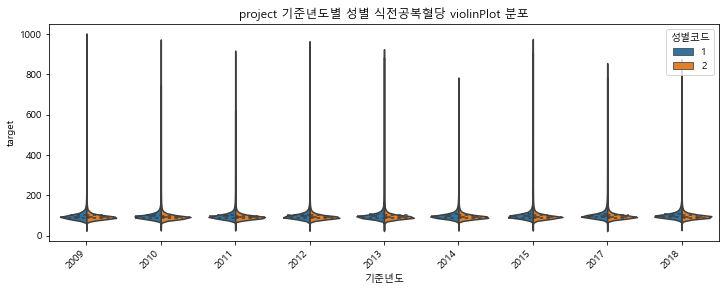

In [22]:
# violinplot : boxplot + 데이터 분포까지
plt.figure(figsize=(12,4))
font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
mpl.rc('font', family=font_name) 
ax = sns.violinplot(x=df["기준년도"],y=df['target'],data=df,hue=df['성별코드'],split='True',inner="quartile") # inner="stick"
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.title(f'project 기준년도별 성별 식전공복혈당 violinPlot 분포')
plt.savefig(f"./img/violin_plot.png", bbox_inches='tight') # dpi=100

In [5]:
df['target_CAT'] = df['target'].apply(lambda x: 13 if x >= 800 else 
                                               ( 12 if 700 <= x < 800 else 
                                               ( 11 if 600 <= x < 700 else 
                                               ( 10 if 500 <= x < 600 else
                                               ( 9 if 400 <= x < 500 else
                                               ( 8 if 300 <= x < 400 else
                                               ( 7 if 200 <= x < 300 else
                                               ( 6 if 126 <= x < 200 else    # 당뇨로 진단
                                               ( 5 if 100 <= x < 126 else    # 공복혈당장애 
                                               ( 4  if  70 <= x < 100 else   # 정상
                                               ( 3  if  50 <= x < 70 else 
                                               ( 2  if  10 <= x < 50 else  1 )))))))))))
                                     
                                     )

In [6]:
df['target_CAT'].value_counts()

4     5317287
5     2081331
6      445322
7       65549
3       54487
8        9252
9        1339
2         529
10        287
11         71
12         23
13         15
Name: target_CAT, dtype: int64

In [7]:
cat_mapping={
            13 : '800over',
            12 : '700 ~ 800',
            11 : '600 ~ 700', 
            10 : '500 ~ 600', 
            9 : '400 ~ 500', 
            9 : '300 ~ 400', 
            7 : '200 ~ 300', 
            6 : '126 ~ 200', # 당뇨로 진단
            5 : '100 ~ 126', # 공복혈당장애 
            4 : '70 ~ 100',  # 정상
            3 : '50 ~ 70', 
            2 : '10 ~ 50', 
            1 : '10under' }
df['target_CAT_map'] = df['target_CAT'].map(cat_mapping)

In [8]:
df['target_CAT_map'].value_counts()

70 ~ 100     5317287
100 ~ 126    2081331
126 ~ 200     445322
200 ~ 300      65549
50 ~ 70        54487
300 ~ 400       1339
10 ~ 50          529
500 ~ 600        287
600 ~ 700         71
700 ~ 800         23
800over           15
Name: target_CAT_map, dtype: int64

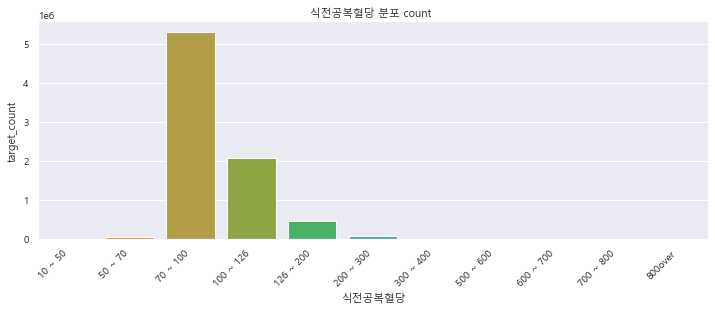

In [9]:
df_=df.groupby(['target_CAT','target_CAT_map'])[[ 'target_CAT_map']].count()
df_.columns = ['target_count' ]
df_ = df_.reset_index()
df_ = df_.set_index('target_CAT_map')
def Plot(df):
    plt.figure(figsize=(12,4))
    sns.set(font_scale=0.9)
    font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
    mpl.rc('font', family=font_name) # ahronbd.ttf
       # 한글깨짐 리눅스
#     mpl.rcParams['font.family'] = 'NanumGothic'
#     mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df_.index, y=df_['target_count'], data=df_)
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('식전공복혈당')
    plt.title(f'식전공복혈당 분포 count ')
#     plt.savefig(f"./img/visual/age.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_)

### Reg target outlier remove

In [11]:
df.shape[0]

7975492

In [10]:
remove_cat = ['300 ~ 400', '10 ~ 50', '500 ~ 600', '600 ~ 700', '700 ~ 800', '800over']
for cat in remove_cat:
    df = df[ df['target_CAT_map'] != cat ]
print(df.shape[0])

7973228


In [11]:
df['target_dist'] = df['target'].map(lambda x:  1 if x >= 126 else 0)

In [12]:
tmp_lst=df['target_dist'].value_counts().values
print(f'정상(target < 126 ) {np.round((tmp_lst[0]/tmp_lst.sum())*100, 2)}%')
print(f'당뇨(target >= 126 ) {np.round((tmp_lst[1]/tmp_lst.sum())*100, 2)}%')
# 6.54% ---> 6.52%

정상(target < 126 ) 93.48%
당뇨(target >= 126 ) 6.52%


In [13]:
df.columns

Index(['기준년도', '성별코드', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '총콜레스테롤', '트리글리세라이드',
       'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST',
       '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부', 'target', '연령',
       'target_CAT', 'target_CAT_map', 'target_dist'],
      dtype='object')

In [14]:
df.drop(['target_CAT','target_CAT_map','target_dist'], axis=1, inplace=True)

In [34]:
df.to_csv('./data/NHIS_model_reg_2.csv', sep=',', encoding='utf-8', index=False)

### Reg target Log 변환

[Text(0, 0, '2009'),
 Text(1, 0, '2010'),
 Text(2, 0, '2011'),
 Text(3, 0, '2012'),
 Text(4, 0, '2013'),
 Text(5, 0, '2014'),
 Text(6, 0, '2015'),
 Text(7, 0, '2017'),
 Text(8, 0, '2018')]

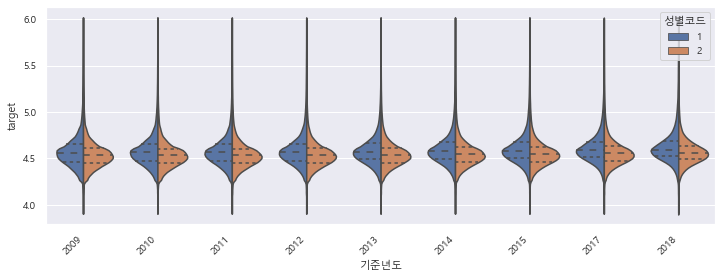

In [15]:
df['target'] = np.log1p(df['target'])
plt.figure(figsize=(12,4))
font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
mpl.rc('font', family=font_name) 
ax = sns.violinplot(x=df["기준년도"], y=df['target'], data=df, hue=df['성별코드'], split='True', inner="quartile")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 

In [ ]:
## 시간 오래걸림
# df_target = pd.Series(df['target'])
# ax = sns.barplot(x=df_target.index, y=df_target )
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 

### Reg 상관관계 corr

### Reg 다중공선선 확인 VIF

In [20]:
df = pd.read_csv('data/NHIS_model_reg_2.csv')
y_target = df['target']
X_features = df.drop(['target'], axis=1,inplace=False)

from statsmodels.stats.outliers_influence import variance_inflation_factor
# 피처마다의 VIF(분산팽창요인, Variance Inflation Factor) 계수를 출력합니다.
# VIF계수가 10 ~ 15 정도를 넘으면 다중 공선성의 문제가 발생했다고 판단
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_features.values, i) for i in range(X_features.shape[1])]
vif["features"] = X_features.columns
vif.round(1)

,VIF Factor,features
0,1831.7,기준년도
1,34.8,성별코드
2,7.9,시도코드
3,1106.8,신장(5Cm단위)
4,152.7,체중(5Kg단위)
5,277.1,허리둘레
6,19.0,시력(좌)
7,19.1,시력(우)
8,56.6,청력(좌)
9,59.0,청력(우)


### Reg VIF 임계값 설정 feature selection

In [21]:
vif_remove = vif[ vif["VIF Factor"] > 20 ]
print(vif_remove.round(1))
vif_remove['features'].values

    VIF Factor   features
0       1831.7       기준년도
1         34.8       성별코드
3       1106.8  신장(5Cm단위)
4        152.7  체중(5Kg단위)
5        277.1       허리둘레
8         56.6      청력(좌)
9         59.0      청력(우)
10       177.5      수축기혈압
11       145.1      이완기혈압
12       171.8     총콜레스테롤
15        58.6   LDL콜레스테롤
16       154.0        혈색소


array(['기준년도', '성별코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '청력(좌)', '청력(우)',
       '수축기혈압', '이완기혈압', '총콜레스테롤', 'LDL콜레스테롤', '혈색소'], dtype=object)

In [23]:
df = pd.read_csv('data/NHIS_model_reg_2.csv')
print(df.shape[0])
vif_remove_features = vif_remove['features'].values
df.drop(vif_remove_features, axis=1, inplace=True)
print(df.shape[0])
df.to_csv('./data/NHIS_model_reg_3_vif.csv', sep=',', encoding='utf-8', index=False)

7973228
7973228


### Clf 분산분석 ANOVA F-TEST이용한 feature selection
* numeric input and categorical output
* https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [4]:
df = pd.read_csv('data/NHIS_model_reg_2.csv')
df['target_'] = df['target'].map(lambda x:  1 if x >= 126 else 0)
y_target = df['target_']
X_features = df.drop(['target','target_'], axis=1,inplace=False)

In [5]:
from sklearn.feature_selection import f_classif
[f_stat, f_p_value] = f_classif(X_features, y_target)

In [6]:
f_test_df = pd.DataFrame({'Feature':X_features.columns,
                            'F statistic':f_stat,
                            'p value':f_p_value})
f_test_df.sort_values('p value')
# p value값이 0.05이하이면 

,Feature,F statistic,p value
0,기준년도,4541.326244,0.000000e+00
22,흡연상태,12031.824157,0.000000e+00
21,감마지티피,139311.115914,0.000000e+00
20,(혈청지오티)ALT,79646.270693,0.000000e+00
19,(혈청지오티)AST,49120.440593,0.000000e+00
18,혈청크레아티닌,10122.896417,0.000000e+00
17,요단백,74321.138028,0.000000e+00
16,혈색소,13742.652880,0.000000e+00
15,LDL콜레스테롤,6484.929687,0.000000e+00
14,HDL콜레스테롤,36945.005814,0.000000e+00


In [42]:
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(f_classif, percentile=20) 
selector.fit(X_features, y_target)
best_feature_ix = selector.get_support()
best_features = [X_features.columns[counter] for counter in range(len(X_features.columns)) if best_feature_ix[counter]]
best_features

['허리둘레', '수축기혈압', '트리글리세라이드', '감마지티피', '연령', 'target_']

### Reg pearson's correlation feature selection for numeric input and numeric output

In [25]:
df = pd.read_csv('data/NHIS_model_reg_2.csv')
y_target = df['target']
X_features = df.drop(['target'], axis=1,inplace=False)
# X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=156)

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
selector = SelectPercentile(f_regression, percentile=50) 
selector.fit(X_features, y_target)
best_feature_ix = selector.get_support()
best_features = [X_features.columns[counter] for counter in range(len(X_features.columns)) if best_feature_ix[counter]]
best_features

['성별코드',
 '체중(5Kg단위)',
 '허리둘레',
 '시력(좌)',
 '시력(우)',
 '수축기혈압',
 '이완기혈압',
 '트리글리세라이드',
 '요단백',
 '(혈청지오티)AST',
 '(혈청지오티)ALT',
 '감마지티피',
 '연령']

In [29]:
df= df[best_features]
df['target'] = y_target
print(df.columns)
df.to_csv('./data/NHIS_model_reg_4_corr.csv', sep=',', encoding='utf-8', index=False)

Index(['성별코드', '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '수축기혈압', '이완기혈압',
       '트리글리세라이드', '요단백', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '연령', 'target'],
      dtype='object')


In [41]:
# df = pd.read_csv('data/NHIS_model_reg_2.csv')
# y_target = df['target']
# X_features = df.drop(['target'], axis=1,inplace=False)
# # X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=156)

# # X_features = pd.get_dummies(X_features)
# # define feature selection
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# fs = SelectKBest(score_func=f_regression, k=)
# # apply feature selection
# X_selected = fs.fit_transform(X_features, y_target)
# print(X_selected.shape)
# X_temp = X_selected[:3]
# X_temp

(7975492, 15)


array([[  2. ,  40. ,  62. ,   1. ,   1. , 110. ,  70. ,  41. ,  76. ,
         12.9,   1. ,  22. ,  24. ,  11. ,  22. ],
       [  2. ,  40. ,  67. ,   1.2,   1.2, 113. ,  61. ,  59. ,  55. ,
         13.5,   1. ,  22. ,  16. ,  12. ,  22. ],
       [  2. ,  45. ,  64. ,   1.5,   1.5, 110. ,  70. ,  82. ,  57. ,
         12.8,   1. ,  21. ,  12. ,  10. ,  22. ]])

### Reg statsmodels

In [8]:
df = pd.read_csv('data/NHIS_model_reg_2.csv')
y_target = df['target']
X_features = df.drop(['target'], axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=156)

In [9]:
import statsmodels.api as sm
# statsmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train.values, X_train.values).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 2.817e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:45:00   Log-Likelihood:            -2.5009e+07
No. Observations:             5581259   AIC:                         5.002e+07
Df Residuals:                 5581232   BIC:                         5.002e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        606.2170      9.171     66.105      0.000     588.243     624.191
x1            -0.2722      0.005    -59.352      0.000      -0.281      -0.263
x2            -1.1674      0.035    -33.435      0.000      -1.236      -1.099
x3             0.0123      0.001     17.290      0.000       0.011       0.014
x4            -0.0491      0.002    -26.551      0.000      -0.053      -0.045
x5            -0.0393      0.002    -22.405      0.000      -0.043      -0.036
x6             0.2556      0.002    135.019      0.000       0.252       0.259
x7            -1.3394      0.039    -34.506      0.000      -1.416      -1.263
x8            -1.4993      0.039    -38.475      0.000      -1.576      -1.423
x9             0.1107      0.065      1.690      0.091      -0.018       0.239
x10            0.1195      0.067      1.785      0.074      -0.012       0.251
x11            0.1107      0.001    112.465      0.000       0.109       0.113
x12           -0.0188      0.001    -13.232      0.000      -0.022      -0.016
x13            0.0007      0.001      1.135      0.257      -0.000       0.002
x14            0.0269      0.000    184.666      0.000       0.027       0.027
x15           -0.0023      0.001     -3.515      0.000      -0.004      -0.001
x16           -0.0117      0.001    -20.096      0.000      -0.013      -0.011
x17            0.1052      0.008     13.187      0.000       0.090       0.121
x18            4.4664      0.023    197.539      0.000       4.422       4.511
x19            0.5054      0.036     13.986      0.000       0.435       0.576
x20           -0.0794      0.001    -81.286      0.000      -0.081      -0.078
x21            0.0727      0.001     99.604      0.000       0.071       0.074
x22            0.0476      0.000    169.908      0.000       0.047       0.048
x23            0.0276      0.014      2.000      0.045       0.001       0.055
x24            0.0608      0.019      3.236      0.001       0.024       0.098
x25           -0.5647      0.019    -29.660      0.000      -0.602      -0.527
x26            0.2020      0.001    261.859      0.000       0.201       0.204
==============================================================================
Omnibus:                  4862683.685   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        220247018.450
Skew:                           4.047   Prob(JB):                         0.00
Kurtosis:                      32.691   Cond. No.                     2.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'coef')

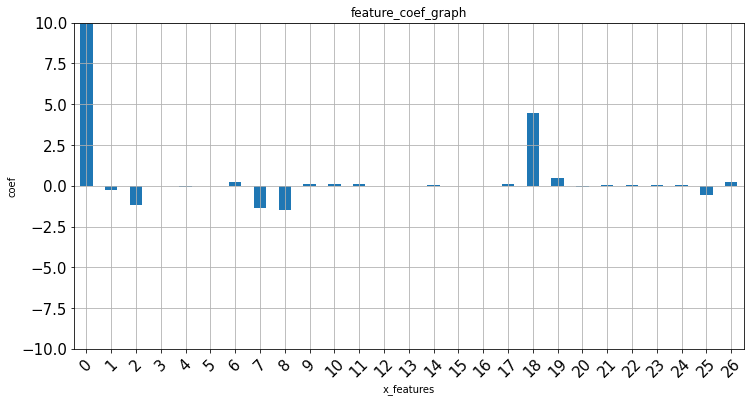

In [13]:
# 회귀 계수를 리스트로 반환합니다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환합니다.
# x_labels = model.params.index.tolist()

# 회귀 계수를 출력합니다.
ax = coefs_series.plot(kind='bar', figsize=(12,6),grid=True, rot=45, fontsize=15 )
ax.set_ylim(-10, 10)
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
# ax.set_xticklabels(x_labels)

## REG target sampling 

In [64]:
df = pd.read_csv('data/NHIS_total_model.csv')
df['target'] = df['식전혈당(공복혈당)']
df.drop('식전혈당(공복혈당)', axis=1, inplace=True)    
# 연령대 코드 --> 연령 decoding 후 drop
df['연령'] =df['연령대코드(5세단위)'].apply( lambda x: x*5 + 17 )
df.drop('연령대코드(5세단위)', axis=1, inplace=True)

# df.to_csv('./data/NHIS_model_reg_1.csv', sep=',', encoding='utf-8', index=False)

df['target_dist'] = df['target'].map(lambda x:  1 if x >= 126 else 0)

tmp_lst=df['target_dist'].value_counts().values
print(f'정상(target < 126 ) {np.round((tmp_lst[0]/tmp_lst.sum())*100, 2)}%')
print(f'당뇨(target >= 126 ) {np.round((tmp_lst[1]/tmp_lst.sum())*100, 2)}%')

df_copy = df.copy()
# filter
target_count = df_copy[ df_copy['target_dist'] == 1 ].shape[0]
not_target_count = df_copy[ df_copy['target_dist'] != 1 ].shape[0]
# print(target_count)

# frac 설정 # if (target_count/not_target_count)*2 ==> target 33.3%비율(전체 156만)
frac=round( (target_count/not_target_count)*3, 3) 
df_target = df_copy[ df_copy['target_dist'] == 1 ]
df_X =  df_copy[ df_copy['target_dist'] != 1 ].sample(frac=frac, random_state=1)

# concat
df = pd.concat ([df_target, df_X]).sort_values(by=['기준년도'])

target_count = df[df['target_dist'] == 1].shape[0]
target_ex_count = df[df['target_dist'] != 1].shape[0]
print(f"target   count : {target_count} ({ round( target_count/df.shape[0], 4)*100 })%")
print(f"target외 count : {target_ex_count} ({ round( target_ex_count/df.shape[0], 4)*100 })%")
# shuffle
df.drop('target_dist', axis=1,inplace=True)
import sklearn
df = sklearn.utils.shuffle(df)

df.to_csv('./data/NHIS_model_reg_4_sampling_3_1.csv', sep=',', encoding='utf-8', index=False)

정상(target < 126 ) 93.46%
당뇨(target >= 126 ) 6.54%
target   count : 521858 (25.0)%
target외 count : 1565263 (75.0)%
